# Setup

In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
import re
from os import chdir, getcwd, listdir, mkdir
from os.path import join
import pkg_resources
import pickle
import nltk
nltk.download('averaged_perceptron_tagger')
from scipy.linalg import norm
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [105]:
GET_FILES_LOCALLY = True # True: local files from cloned repo; False: URL from GitHub
HOME = getcwd()

In [4]:
package_list = [pkg for pkg in pkg_resources.working_set]

if 'googletrans' not in [pkg.key for pkg in package_list]:
    ! pip install googletrans==3.1.0a0
import googletrans
    
if 'pdfplumber' not in [pkg.key for pkg in package_list]:
    ! pip install pdfplumber
import pdfplumber

---   
# Projection

Objective: find requirements of similar semantic content.

---

<img src="images/requirement_comparison.png">

## Setup

In [40]:
if GET_FILES_LOCALLY == True:
    URL_FAA = join(HOME, 'Regulations', 'FAR_Part121_nodes.xlsx')
    URL_ANAC = join(HOME, 'Regulations', 'RBAC121_nodes.xlsx')
    URL_TOKENIZER = join(HOME, 'models', 'tokenizer___2021-04-16_10-58-15.h5')
    URL_EMBEDDING_LAYER = join(HOME, 'models', 'embedding_layer___2021-04-16_10-58-15.h5')

In [41]:
def relevant_words(excerpt):
    tokens = re.findall('[a-zA-Z]{3,}', excerpt)
    words, allowed_pos = [], ['NN','NNS','NNP','NNPS','JJ','RB','VB','VBG','VBN','VBP','VBZ','VBD']
    for item in nltk.pos_tag(tokens):
        if item[0] not in words and item[1] in allowed_pos:
            words.append(item[0])
    return words

def sorted_keywords(words, tokenizer):
    w,f = [], []

    for word in words:
        if word in tokenizer.word_index.keys():
            w.append(word)
            f.append(tokenizer.word_counts[word])

    sorting_indices = np.array(f).argsort()
    return np.array(w)[sorting_indices]

def jaccard_mod(string1, string2, max_words = None):
    # with max_words != None, repetitions are ignored, only the frequency in the original dictionary is used
    # with max_words == None, repetitions are somewhat accounted for (not very thoughtfully..)
    
    cutoff = .5
    
    if max_words == None:
        tokens1 = tokenizer.texts_to_sequences(relevant_words(string1))
        tokens2 = tokenizer.texts_to_sequences(relevant_words(string2))
    else:
        tokens1 = sorted_keywords(relevant_words(string1), tokenizer)
        tokens1 = tokenizer.texts_to_sequences(tokens1[:max_words])
        tokens2 = sorted_keywords(relevant_words(string2), tokenizer)
        tokens2 = tokenizer.texts_to_sequences(tokens2[:max_words])
        
    if len(tokens1) < 2 or len(tokens2) < 2:
        return 0
    else:
        embedding1 = embedding_layer(np.array(tokens1)).numpy().squeeze()
        norms1 = norm(embedding1, axis=1)
        embedding1 = embedding1[norms1 != 0]
        norms1 = norms1[norms1 != 0].reshape([-1,1])

        embedding2 = embedding_layer(np.array(tokens2)).numpy().squeeze()
        norms2 = norm(embedding2, axis=1)
        embedding2 = embedding2[norms2 != 0]
        norms2 = norms2[norms2 != 0].reshape([-1,1])

        cosine_similarity = np.matmul(embedding1, embedding2.T) / norms1 / norms2.T
        tril = np.ones_like(cosine_similarity) * (np.tril(cosine_similarity) != 0).astype(int)

        intersection = np.sum((cosine_similarity * cosine_similarity) > cutoff)
        union = cosine_similarity.shape[0] + cosine_similarity.shape[1] - intersection

        return intersection/union

In [42]:
df_FAA = pd.read_excel(URL_FAA)[['title','requirement']]
df_ANAC = pd.read_excel(URL_ANAC)[['title','requirement']]
translator = googletrans.Translator()

with open(URL_TOKENIZER, 'rb') as file:
    tokenizer = pickle.load(file)

with open(URL_EMBEDDING_LAYER, 'rb') as file:
    embedding_layer = pickle.load(file)

## Demo: find FAA requirement corresponding to given ANAC requirement

* Choose ANAC requirement randomly
* Translate requirement
* Compare with list of FAA requirements
    - Tokenize
    - Filter parts-of-speech
    - Sort words according to importance
    - Identify similar words
    - Compare shared words
* Print best match

Requirement: RBAC 121.357(c)(1)

121.357  Requisitos para radar meteorológico de bordo 
(c) Cada pessoa operando um avião no qual seja requerido um radar meteorológico instalado, quando voando esse avião segundo este regulamento, deve atender ao seguinte: (1) despacho. Ninguém pode despachar um avião (ou iniciar o voo de um avião no caso de detentor de certificado que não usa um sistema de despacho) em voo VFR noturno ou IFR se as informações ou previsões meteorológicas conhecidas indicarem que trovoadas ou outros fenômenos meteorológicos potencialmente perigosos, capazes de serem detectados por um radar meteorológico de bordo, são esperados ao longo da rota a ser voada, a menos que o radar meteorológico do avião esteja em condições operativas satisfatórias; 


Translated requirement:

121.357 Requirements for onboard weather radar
(c) Each person operating an airplane on which an installed weather radar is required, when flying that airplane in accordance with this regulation, must co

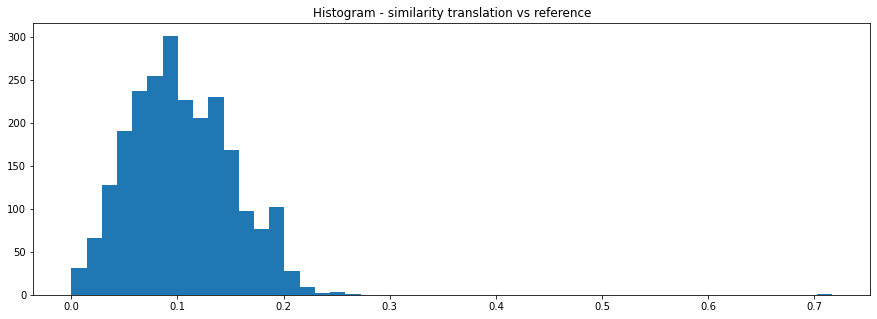

In [110]:
EXAMPLE_NUMBER = np.random.randint(0,df_ANAC.shape[0])

req = df_ANAC.requirement[EXAMPLE_NUMBER]
title = df_ANAC.title[EXAMPLE_NUMBER]
print('Requirement: RBAC {}\n\n{}'.format(title,req))

translation = translator.translate(req, dest='en', src='pt').text

print('\n\nTranslated requirement:\n\n{}\n\n'.format(translation))

similarity = []
for ref in df_FAA.requirement:
    similarity.append(jaccard_mod(translation, ref))
    
match_index = np.array(similarity).argmax()
print('Match: FAR {}'.format(df_FAA.title[match_index]))
print('Similarity index: {}\n'.format(np.max(similarity)))
print('Matching requirement text:\n\n{}'.format(df_FAA.requirement[match_index]))

plt.figure(figsize = (15,5))
plt.hist(np.array(similarity), 50)
plt.title('Histogram - similarity translation vs reference')
plt.show()

## Demo: find match to user input

-> Paste an operational requirement below:

Personnel or crew members other than cabin crew in the passenger compartment  The operator shall ensure that personnel or crew members, other than operating cabin crew members, carrying out their duties in the passenger compartment of an aircraft:  (a) are not confused by the passengers with operating cabin crew members;

Match: FAR § 121.391(a)(3)
Similarity index: 0.2962962962962963

Matching requirement text:

§ 121.391   Flight attendants.
(a) Except as specified in § 121.393 and § 121.394, each certificate holder must provide at least the following flight attendants on board each passenger-carrying airplane when passengers are on board:
(3) For airplanes having a seating capacity of more than 50 but less than 101 passengers - two flight attendants. 



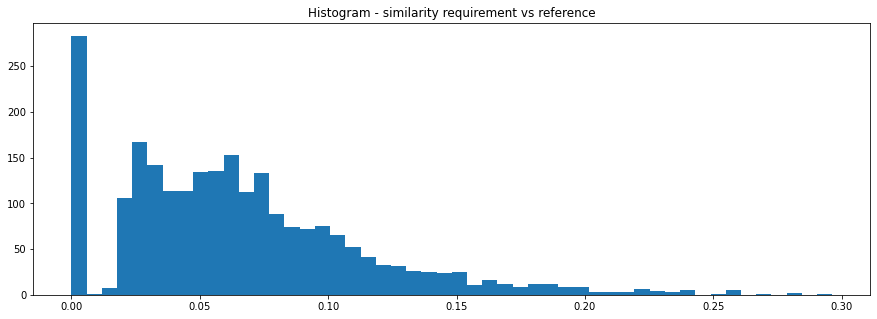

In [109]:
req = input('-> Paste an operational requirement below:\n\n')

similarity = []
for ref in df_FAA.requirement:
    similarity.append(jaccard_mod(req, ref))
    
match_index = np.array(similarity).argmax()
print('\nMatch: FAR {}'.format(df_FAA.title[match_index]))
print('Similarity index: {}\n'.format(np.max(similarity)))
print('Matching requirement text:\n\n{}'.format(df_FAA.requirement[match_index]))

plt.figure(figsize = (15,5))
plt.hist(np.array(similarity), 50)
plt.title('Histogram - similarity requirement vs reference')
plt.show()

## Improvements:

* Include more references (EASA, ICAO)
* Better parameter tuning:
    - number of relevant words to compare
    - threshold for 'similar' words
* Other keyword identification techniques
* Other similarity metrics
* Different word embeddings
* Sentence embeddings (compare meaning at sentence level)

---   
# Classification

Objective: read requirement and classify in either "Title Only", "Aircraft" or "Operator"   

-----   

<img src="images/requirement_classification.png">

# Setup

In [29]:
if GET_FILES_LOCALLY == True:
    URL_FAA = join(HOME, 'Regulations', 'FAR_Part121_nodes_labelled.xlsx')
    URL_ANAC = join(HOME, 'Regulations', 'RBAC121_nodes.xlsx')
    URL_MODEL = join(HOME, 'Models', 'model___2021-04-15_16-21-35___Bidirectional_GRU_Softmax.h5')
    URL_TOKENIZER = join(HOME, 'Models', 'tokenizer___2021-04-15_16-11-22.h5')

# if importing from GitHub
############
############

In [30]:
df_FAA = pd.read_excel(URL_FAA)[['title','requirement','label','tag']]
df_ANAC = pd.read_excel(URL_ANAC)[['title','requirement']] # + label + tag!!!
translator = googletrans.Translator()

with open(URL_TOKENIZER, 'rb') as file:
    tokenizer_classification = pickle.load(file)
    
model = tf.keras.models.load_model(URL_MODEL)

In [31]:
sequence_length = 200

## Demo: classify random FAA requirement

* Select FAA part 121 requirement randomly
* Tokenize
* Pad/trim sequence to 200 tokens
* Run through classification model
* Choose class according to highest probability

In [32]:
EXAMPLE_NUMBER = np.random.randint(0,df_FAA.shape[0])

req = df_FAA.requirement[EXAMPLE_NUMBER]
title = df_FAA.title[EXAMPLE_NUMBER]
correct_tag = df_FAA.tag[EXAMPLE_NUMBER].title()
print('Requirement: {}\n\n{}'.format(title,req))

tokens = tokenizer_classification.texts_to_sequences([req])
padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen = sequence_length)
X = tf.constant(np.array(padded_tokens))
prediction = model.predict(X)
predicted_prob = prediction.max()
predicted_label = prediction.argmax()
predicted_tag = ['Title Only', 'Aircraft', 'Operator'][predicted_label]

print('Predicted label: {}\nLevel of Confidence: {}%'.format(predicted_tag, np.round(100*predicted_prob,3)))
print('\nCorrect label: {}'.format(correct_tag))

Requirement: § 121.221(f)(1)

§ 121.221   Fire precautions.
(f) Class E. On airplanes used for the carriage of cargo only, the cabin area may be classified as a Class “E” compartment. Each Class E compartment must comply with the following: 
(1) It must be completely lined with fire-resistant material. 

Predicted label: Aircraft
Level of Confidence: 99.945%

Correct label: Aircraft


## Demo: classify random ANAC requirement

* Select ANAC RBAC 121 requirement randomly
* Translate to English
* Tokenize
* Pad/trim sequence to 200 tokens
* Run through classification model
* Choose class according to highest probability

In [33]:
EXAMPLE_NUMBER = np.random.randint(0,df_ANAC.shape[0])

req = df_ANAC.requirement[EXAMPLE_NUMBER]
title = df_ANAC.title[EXAMPLE_NUMBER]
#correct_tag = df_ANAC.tag[EXAMPLE_NUMBER].title()
print('Requirement: {}\n\n{}'.format(title,req))

translation = translator.translate(req, dest='en', src='pt').text

print('\n\nTranslated requirement:\n\n{}\n\n'.format(translation))

tokens = tokenizer_classification.texts_to_sequences([translation])
padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen = sequence_length)
X = np.array(padded_tokens)
X = tf.constant(X)
prediction = model.predict(X)
predicted_prob = prediction.max()
predicted_label = prediction.argmax()
predicted_tag = ['Title Only', 'Aircraft', 'Operator'][predicted_label]

print('Predicted label: {}\nLevel of Confidence: {}%'.format(predicted_tag, np.round(100*predicted_prob,3)))
#print('\nCorrect label: {}'.format(correct_tag))

Requirement: 121.633(b)(2)

121.633  Sistema de tempo limite no planejamento de alternativa ETOPS 
(b) Para ETOPS além de 180 minutos, ninguém pode listar um aeródromo de alternativa ETOPS em um despacho ou liberação de voo se o tempo necessário para voar até este aeródromo: (2) em velocidade de cruzeiro com um motor inoperante, corrigida pelo vento e temperatura, exceder o tempo do Sistema Significativo ETOPS mais limitante do avião (outro que não o tempo mais limitante dos sistemas de supressão de fogo do avião menos 15 minutos para os compartimentos de carga e bagagem para os quais seja requerido pela regulamentação ter sistemas de supressão de fogo). 


Translated requirement:

121,633 Timeout system in ETOPS alternative planning
(b) For ETOPS beyond 180 minutes, no one can list an alternative ETOPS aerodrome in a dispatch or flight release if the time required to fly to this aerodrome: (2) at cruising speed with an inoperative engine, corrected by the wind and temperature, exceedi

## Demo: classify user input

* Ask for requirement as input (in English)
* Tokenize
* Pad/trim sequence to 200 tokens
* Run through classification model
* Choose class according to highest probability

In [216]:
REQUIREMENT = input('-> Paste an operational requirement below:\n\n')

tokens = tokenizer_classification.texts_to_sequences([REQUIREMENT])
padded_tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen = sequence_length)
X = np.array(padded_tokens)
X = tf.constant(X)
prediction = model.predict(X)
predicted_prob = prediction.max()
predicted_label = prediction.argmax()
predicted_tag = ['Title Only', 'Aircraft', 'Operator'][predicted_label]

print('\nPredicted label: {}\nLevel of Confidence: {}%'.format(predicted_tag, np.round(100*predicted_prob,3)))

--> Paste an operational requirement below:

CAT.GEN.MPA.185    Information to be retained on the ground  (a) The operator shall ensure that at least for the duration of each flight or series of flights:  (1) information relevant to the flight and appropriate for the type of operation is preserved on the ground;  (2) the information is retained until it has been duplicated at the place at which it will be stored; or, if this is impracticable  (3) the same information is carried in a fireproof container in the aircraft.  (b) The information referred to in (a) includes:  (1) a copy of the operational flight plan, where appropriate;  (2) copies of the relevant part(s) of the aircraft technical log;  (3) route-specific NOTAM documentation if specifically edited by the operator;  (4) mass and balance documentation if required; and  (5) special loads notification.

Predicted label: Operator
Level of Confidence: 84.371%


## Improvements:

* More categories
* Feature engineering
* Larger dataset: more sophisticated models without overfitting
* Better embeddings: context sensitive, other datasets, multilingual, sentence embedding

## Teaser

### Applications of Natural Language Processing:

* ___Machine Translation___
* Speech Recognition
* Sentiment Analysis
* ___Question Answering___
* ___Summarization of Text___
* Chatbot
* Intelligent Systems
* ___Text Classification___
* Character Recognition
* Spell Checking
* ___Spam Detection___
* Autocomplete
* ___Named Entity Recognition___

### Possible projects

* Identify subject of individual requirements or new proposed rules
* Suggest responses to requirements
* Suggest answers to questions based on regulations
* Summarization of new rules
* Suggest affected requirements in DCAs
* "Clean up" regulations